Epoch 0: Accuracy 0.000, Average Loss 2.302184585730235
Epoch 0: Accuracy 0.000, Average Loss 2.302348518371582

Epoch 1: Accuracy 0.887, Average Loss 0.31513941486676533
Epoch 1: Accuracy 0.950, Average Loss 0.15270427167415618

Epoch 2: Accuracy 0.952, Average Loss 0.13682648179431756
Epoch 2: Accuracy 0.976, Average Loss 0.06885536015033722

Epoch 3: Accuracy 0.967, Average Loss 0.09393952153623104
Epoch 3: Accuracy 0.982, Average Loss 0.04632953926920891

Epoch 4: Accuracy 0.973, Average Loss 0.07754946121325096
Epoch 4: Accuracy 0.985, Average Loss 0.040027269441634414

Epoch 5: Accuracy 0.977, Average Loss 0.06724522430449724
Epoch 5: Accuracy 0.986, Average Loss 0.03904806580394506

Epoch 6: Accuracy 0.980, Average Loss 0.05761729689935843
Epoch 6: Accuracy 0.988, Average Loss 0.03271537125110626

Epoch 7: Accuracy 0.982, Average Loss 0.05123410355299711
Epoch 7: Accuracy 0.990, Average Loss 0.028876772802323102

Epoch 8: Accuracy 0.985, Average Loss 0.043605950102210043
Epoch 8

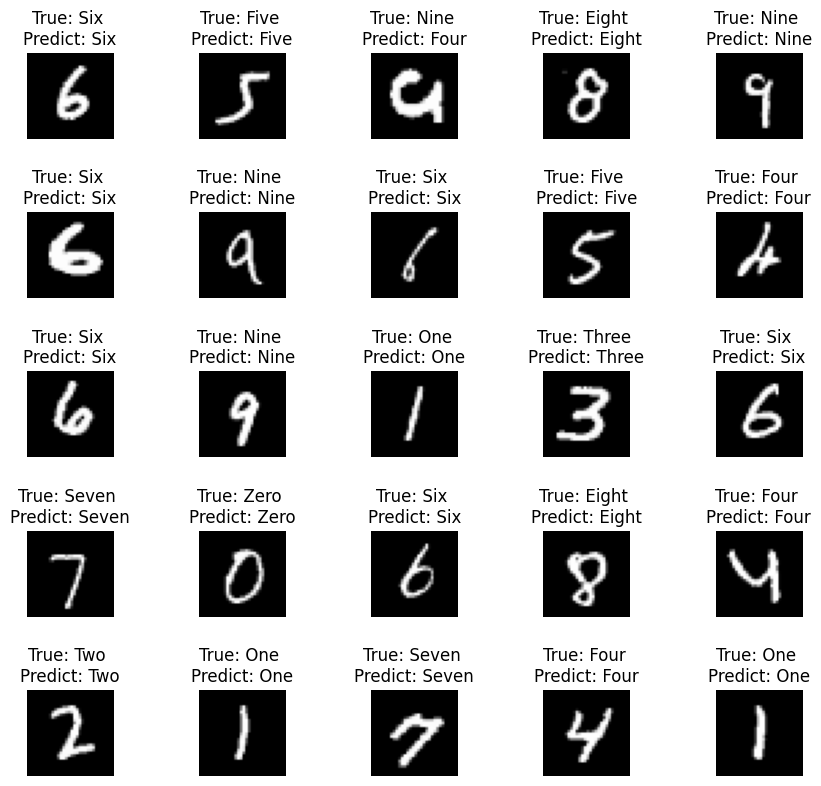

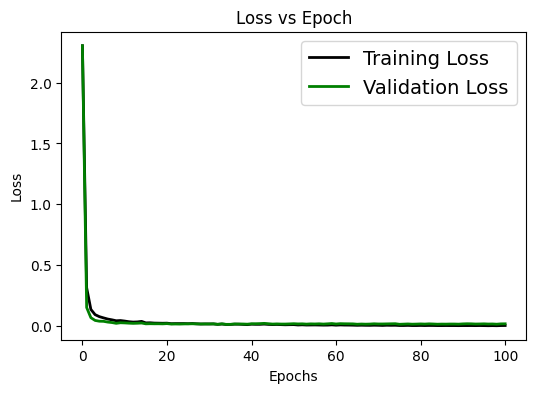

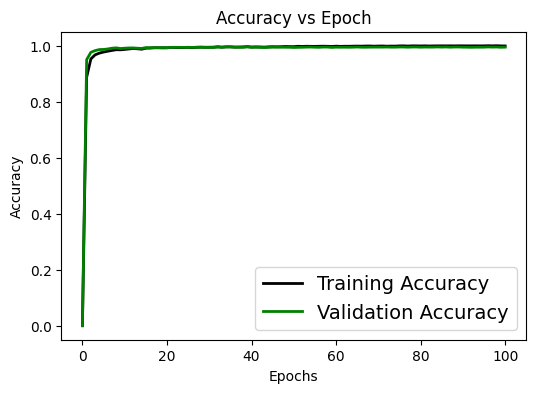

In [4]:
# train the model

from PIL import Image

import numpy as np
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt

from alpineml import Network
from alpineml.layer.reshape import Flatten, Reshape, Transpose
from alpineml.layer.shim import MLX
from alpineml.optim import SGD
from alpineml.function.activation import leaky_relu, softmax, relu
from alpineml.function.loss import CrossEntropyLoss, cross_entropy_loss
from alpineml.layer.core import Linear, Activation
from dataset import get_mnist, get_fashion_mnist, get_cifar10


# Visualize
def viz_sample_predictions(network, test_data, label_map, rows=5, cols=5, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize, num="Sample Predictions")
    axes = axes.reshape(-1)  # flatten

    test_data = test_data.to_buffer().shuffle()
    def sample_random():
        for j in np.arange(0, rows * cols):
            i = np.random.randint(0, len(test_data))
            x = mx.array(test_data[i]['image'])
            y = mx.array(test_data[i]['label'])
            y_pred = network.forward(x[mx.newaxis, ...])

            sample = np.array(255 * x)
            if sample.shape[2] == 3:
                image = Image.fromarray(sample.astype('uint8'))
            else:
                image = Image.fromarray(sample.reshape(sample.shape[0], sample.shape[1]))

            raw_label = mx.argmax(y).item()
            label = label_map[raw_label]

            raw_pred = mx.argmax(y_pred).item()
            pred = label_map[raw_pred]

            axes[j].imshow(image)
            axes[j].set_title(f"True: {label} \nPredict: {pred}")
            axes[j].axis('off')
            plt.subplots_adjust(wspace=1)

    def on_key(event):
        if event.key == ' ':
            sample_random()
            fig.show()

    fig.canvas.mpl_connect('key_press_event', on_key)

    sample_random()


def viz_history(history, figsize=(6, 4)):
    plt.figure(figsize=figsize, num="Loss Curves")
    plt.plot(history['epoch'], history['train_loss'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_loss'], 'green', linewidth=2.0)
    plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title('Loss vs Epoch', fontsize=12)

    plt.figure(figsize=figsize, num="Accuracy Curves")
    plt.plot(history['epoch'], history['train_accuracy'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_accuracy'], 'green', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.title('Accuracy vs Epoch', fontsize=12)


# Evaluate
def eval_model(model, dataset, epoch=None):
    mean_losses = []
    accuracies = []
    predictions = []

    for batch in dataset:
        x_batch = mx.array(batch["image"])
        y_batch = mx.array(batch["label"])

        y_pred = model.forward(x_batch)
        predictions.append(y_pred)

        loss = optimizer.loss_fn(y_pred, y_batch)
        mean_loss = mx.mean(mx.sum(loss, axis=1))
        mean_losses.append(mean_loss.item())

        if isinstance(optimizer.loss_fn, CrossEntropyLoss):
            y_pred = softmax(y_pred)

        errors = mx.sum(mx.abs(y_batch - mx.round(y_pred)), axis=1)
        accuracy = mx.sum(errors == 0) / y_batch.shape[0]
        accuracies.append(accuracy.item())

    mean_loss = sum(mean_losses) / len(mean_losses)
    accuracy = sum(accuracies) / len(accuracies)
    predictions = np.concatenate(predictions)

    dataset.reset()

    if epoch is not None:
        print(f"Epoch {epoch}: Accuracy {accuracy:.3f}, Average Loss {mean_loss}")
    else:
        print(f"Accuracy {accuracy:.3f}, Average Loss {mean_loss}")

    return predictions, accuracy, mean_loss


def train(train_data, epochs, batch_size=1, test_data=None, cb=None):
    batched_train_data = train_data.batch(batch_size)
    batched_test_data = test_data.batch(batch_size)

    def train_epoch():
        for batch in batched_train_data:
            x_batch = mx.array(batch["image"])
            y_batch = mx.array(batch["label"])
            optimizer.step(x_batch, y_batch)
        batched_train_data.reset()

    history = {"epoch": [], "train_loss": [], "test_loss": [], "train_accuracy": [], "test_accuracy": []}

    _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=0)
    _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=0)
    print()
    history["epoch"].append(0)
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_accuracy"].append(train_accuracy)
    history["test_accuracy"].append(test_accuracy)

    for epoch in range(1, epochs + 1):
        train_epoch()

        _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=epoch)
        _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=epoch)
        print()
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_accuracy"].append(train_accuracy)
        history["test_accuracy"].append(test_accuracy)

    test_data.reset()
    eval_model(network, batched_test_data)
    print()

    viz_sample_predictions(network, test_data, label_map)
    viz_history(history)
    plt.show()


train_data, test_data = get_mnist(static=False)
label_map = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]

# train_data, test_data = get_fashion_mnist(static=False)
# label_map = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# train_data, test_data = get_cifar10(static=False)
# label_map = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

network = Network(input_shape=(32, 32, 1))

# conv block 1
network.add_layer(MLX(nn.Conv2d(in_channels=1, out_channels=96, kernel_size=7)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# conv block 2
network.add_layer(MLX(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# feed forward
network.add_layer(Flatten())
network.add_layer(Linear(1024))
network.add_layer(Activation(leaky_relu))
network.add_layer(Linear(10))

optimizer = SGD(eta=0.05, momentum=0.9, weight_decay=0.0005)
optimizer.bind_loss_fn(cross_entropy_loss)
optimizer.bind_network(network)

train(train_data, epochs=100, batch_size=1000, test_data=test_data)


Kernel Shape: (96, 7, 7, 1)
Example: [[[-0.09292741]
  [-0.03083453]
  [ 0.02061116]
  [ 0.12433752]
  [ 0.00484915]
  [-0.17745885]
  [ 0.06242823]]

 [[-0.15243551]
  [-0.05736404]
  [ 0.10986096]
  [ 0.03781015]
  [ 0.00456452]
  [ 0.06900465]
  [ 0.1986337 ]]

 [[ 0.06606362]
  [-0.09808661]
  [-0.14571832]
  [ 0.13701692]
  [ 0.05087516]
  [ 0.19591545]
  [-0.06149338]]

 [[ 0.03600865]
  [-0.167723  ]
  [ 0.01351295]
  [ 0.19421542]
  [ 0.20800917]
  [ 0.01926465]
  [-0.03189522]]

 [[ 0.08047179]
  [ 0.11715252]
  [-0.0609381 ]
  [-0.02673461]
  [ 0.12003401]
  [-0.05998624]
  [ 0.00685939]]

 [[-0.11921604]
  [ 0.06968404]
  [-0.2221059 ]
  [-0.21142893]
  [-0.12481166]
  [ 0.16016252]
  [ 0.15023221]]

 [[-0.03305148]
  [-0.17291135]
  [ 0.02815666]
  [-0.1020136 ]
  [-0.00823323]
  [ 0.09278095]
  [ 0.09851504]]]


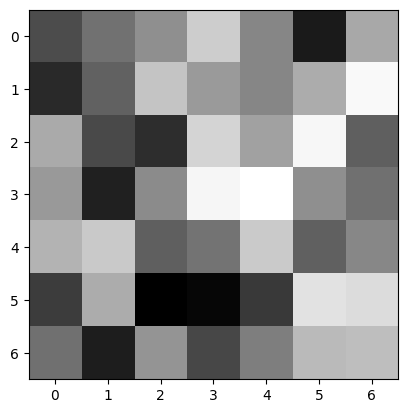

In [8]:
kernels = network.layers[0].params['weight']
kernel = np.array(kernels[50])
print("Kernel Shape:", kernels.shape)
print("Example:", kernel)

def normalize(kernel):
    kernel -= np.min(kernel)
    kernel /= np.max(kernel)
    return 255 * kernel.reshape(kernel.shape[0], kernel.shape[1])

kernel_img = Image.fromarray(normalize(kernel))
plt.imshow(kernel_img)

Mins 0.0
Maxs 1.0


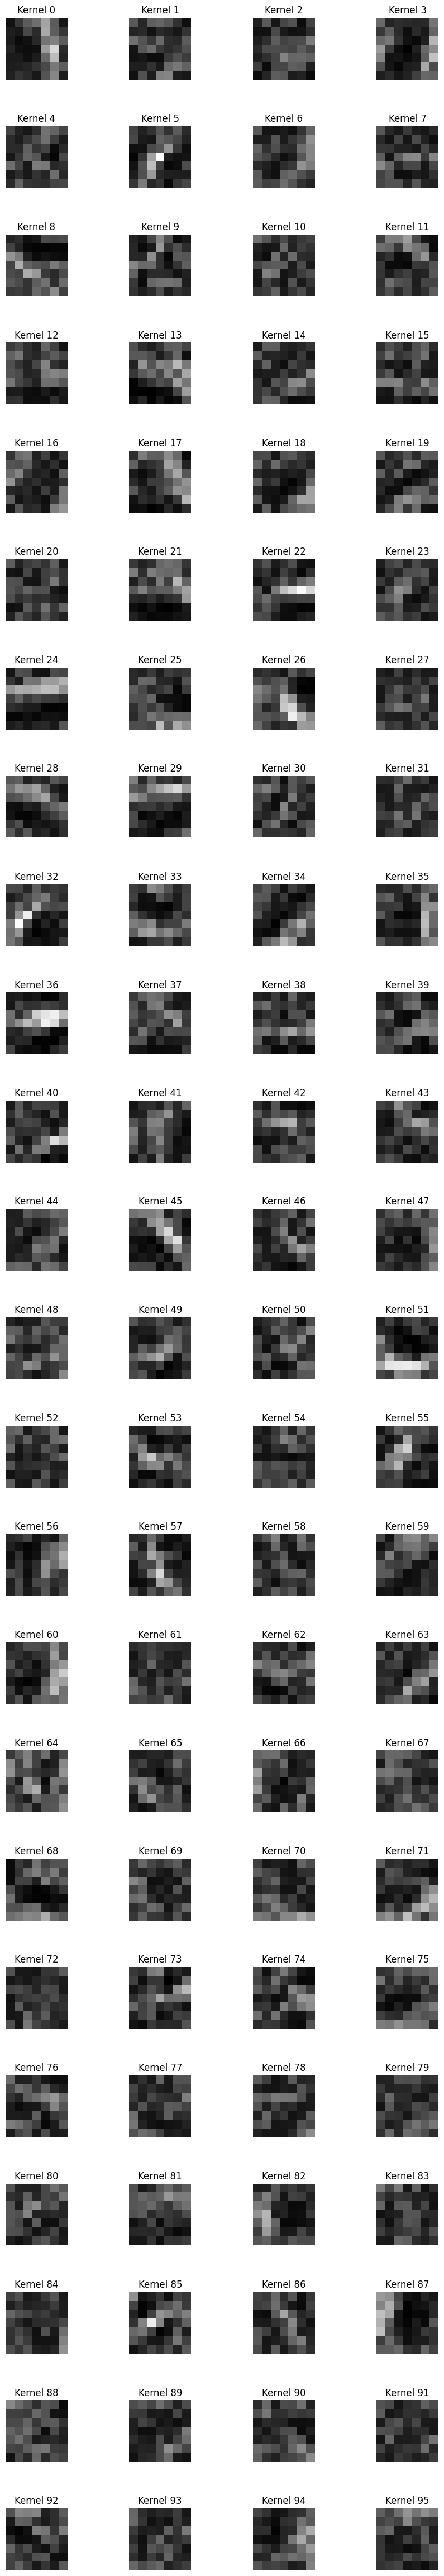

In [17]:
def viz_kernels(kernels, rows=24, cols=4, figsize=(10, 60)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize, num="Sample Predictions")
    axes = axes.reshape(-1)  # flatten

    def normalize_kernels(kernels):
        kernels = np.array(kernels.reshape(kernels.shape[0], kernels.shape[1], kernels.shape[2]))

        kernels = kernels - np.min(kernels)
        kernels = kernels / np.max(kernels)
        kernels = np.square(kernels)

        print("Mins", np.min(kernels))
        print("Maxs", np.max(kernels))

        return kernels

    kernels = normalize_kernels(kernels)

    def normalize(kernel):
        return 255 * kernel

    def imagize(kernel):
        return Image.fromarray(normalize(kernel))

    for j, kernel in enumerate(kernels):
        kernel_img = imagize(kernel)
        axes[j].imshow(kernel_img)
        axes[j].set_title(f"Kernel {j}")
        axes[j].axis('off')
        plt.subplots_adjust(wspace=1)

    plt.show()

viz_kernels(network.layers[0].params['weight'])